# **Feature Selection and Engineering**
---

In [4]:
import pandas as pd
import ordinal_ranking as rank # Move a copy of ordinal_ranking.py to this directory for this import to work
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

In [5]:
RANDOM_STATE = 42

In [6]:
flights_test = pd.read_csv('../files/flights_test_no_missing.csv')
feature_space = list(flights_test.columns)
feature_space.append('arr_delay') # Add the target.

flights = pd.read_csv('../files/flights_no_missing.csv')
flights_subspace = flights[feature_space].copy()
flights_subspace.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay
0,2019-05-19,UA,UA_CODESHARE,UA,4264,EV,N48901,4264,12266,IAH,...,12915,LCH,"Lake Charles, LA",1020,1112,N,52.0,1,127,-2.0
1,2019-05-19,UA,UA_CODESHARE,UA,4266,EV,N12540,4266,13244,MEM,...,12266,IAH,"Houston, TX",1148,1340,N,112.0,1,468,-14.0
2,2019-05-19,UA,UA_CODESHARE,UA,4272,EV,N11164,4272,12266,IAH,...,11042,CLE,"Cleveland, OH",1155,1551,N,176.0,1,1091,4.0
3,2019-05-19,UA,UA_CODESHARE,UA,4281,EV,N13995,4281,11042,CLE,...,11278,DCA,"Washington, DC",839,959,N,80.0,1,310,-20.0
4,2019-05-19,UA,UA_CODESHARE,UA,4286,EV,N13903,4286,13061,LRD,...,12266,IAH,"Houston, TX",710,826,N,76.0,1,301,-1.0


Estimate of prediction set size relative to train/test/validation set:

In [7]:
flights_test.shape[0] / flights.shape[0] * 100

28.165286444822605

### Objective:

Our aim for this section is to use the feature space available to the **flights_test** dataframe containing the target range of dates for our prediction submission (January 1 - 7, 2020, inclusive) to select and engineer a range of fetures that best capture the common causes for flight delays. The prediction submission dates are to be treated as if they are in the future for the purpose of generating an appropriate prediction; as such, no historic data for these dates should be considered. Features will be engineered and selected on the basis of how they best captured the different delay classes available to us during the exploration phase of the study.

## **flights**

Features considered here should be engineered and selected only from the subset present in both **flights** and **flights_test**. Since we know the **flights_test** feature space is a subset of the **flights** feature space, we will simply use the columns in flights_test to filter the feature space of flights to prepare our data for transformation and modelling.

### Feature Selection:

* all ids can be discarded initially (except for the `origin` and `dest` ids), but they may also be ranked by delay if that turns out to be interesting/feasible
* `flights` column is always 1; completely uninformative
* `dup` is always N; completely uninformative
* dest and origin city names information is already captured by origin and destination, but the `state` could be useful in a later iteration (e.g. binarized to something like `busy_state` for high traffic origins/destinations)

In [8]:
to_drop = [
    'mkt_unique_carrier',
    'mkt_carrier',
    'mkt_carrier_fl_num',
    'op_unique_carrier',
    'tail_num',
    'op_carrier_fl_num',
    'origin',
    'dest',
    'dest_city_name',
    'origin_city_name',
    'flights',
    'dup'
    ]

submission_columns = ['fl_date', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin', 'dest']

flights_test_drop = set(to_drop) - set(submission_columns)

flights_subspace = flights_subspace.drop(columns=to_drop)
flights_test = flights_test.drop(columns=flights_test_drop)

### Feature Engineering

#### Ranked categorical features:

In practice, we will always know the planned origin and destination as well as the date of any scheduled flight. It is for this reason that we can confidently engineer our ranking columns prior to splitting the data as these effectively constitute new features that we will always have prior knowledge of when a given flight is scheduled.

`fl_date` can be used to add `day_of_week`, and `month_of_year` columns. These could potentially be reordered by rank of expected delay as well as long as each change is noted for the sake of interpretability.

In [9]:
flights_subspace['day_of_week'] = pd.to_datetime(flights_subspace['fl_date']).dt.dayofweek
flights_subspace['month_of_year'] = pd.to_datetime(flights_subspace['fl_date']).dt.month

flights_test['day_of_week'] = pd.to_datetime(flights_test['fl_date']).dt.dayofweek
flights_test['month_of_year'] = pd.to_datetime(flights_test['fl_date']).dt.month

Now let us check the relationship with arrival delay for these features.

In [10]:
flights_subspace.groupby('day_of_week')['arr_delay'].mean()

day_of_week
0    6.696040
1    4.567373
2    4.458588
3    7.273884
4    6.993864
5    2.512690
6    5.173920
Name: arr_delay, dtype: float64

In [11]:
flights_subspace.groupby('month_of_year')['arr_delay'].mean()

month_of_year
1      3.923047
2      6.693371
3      2.902349
4      4.071800
5      6.448396
6     10.562826
7      8.871938
8      8.883695
9      1.694430
10     2.810083
11     3.071748
12     5.087656
Name: arr_delay, dtype: float64

As we can see above, although we can separate into discrete ranks by mean, some classes are much closer on average than others which is an inherent drawback of this method.

`origin_airport_id` and `dest_airport_id` could also be ordinalized based on expected delay. IDs should be used and the codes discarded becasue these will always refer to the expected airport across years.

In [12]:
categorical_to_ordinal = ['origin_airport_id',
                          'dest_airport_id',
                          'month_of_year',
                          'day_of_week']

# First the core data.
ordinal_df, ordinal_mappings = rank.rank_features_by_mean(flights_subspace, categorical_to_ordinal, 'arr_delay')
ordinal_df.head()

,origin_airport_id_rank,dest_airport_id_rank,month_of_year_rank,day_of_week_rank
0,205.0,62.0,8.0,4.0
1,194.0,196.0,8.0,4.0
2,205.0,235.0,8.0,4.0
3,138.0,182.0,8.0,4.0
4,290.0,196.0,8.0,4.0


In [13]:
ordinal_df.shape

(2339962, 4)

We then combine the ordinalized features with the training set and drop the untransformed categorical columns.

In [14]:
flights_subspace = pd.concat([
    flights_subspace.drop(columns=categorical_to_ordinal),
    ordinal_df],
    axis=1)
    
# Sanity check
print(flights_subspace.shape)
flights_subspace.head()

(2339962, 11)


,fl_date,branded_code_share,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,origin_airport_id_rank,dest_airport_id_rank,month_of_year_rank,day_of_week_rank
0,2019-05-19,UA_CODESHARE,1020,1112,52.0,127,-2.0,205.0,62.0,8.0,4.0
1,2019-05-19,UA_CODESHARE,1148,1340,112.0,468,-14.0,194.0,196.0,8.0,4.0
2,2019-05-19,UA_CODESHARE,1155,1551,176.0,1091,4.0,205.0,235.0,8.0,4.0
3,2019-05-19,UA_CODESHARE,839,959,80.0,310,-20.0,138.0,182.0,8.0,4.0
4,2019-05-19,UA_CODESHARE,710,826,76.0,301,-1.0,290.0,196.0,8.0,4.0


In [15]:
# Checking if the origin IDs in test are necessarily a subset of those in flights.
set(flights_test['origin_airport_id'].unique()).issubset(
    set(flights['origin_airport_id'].unique()))

False

A shortcoming of this strategy is that we are not able to properly rank IDs for which we have no prior delay data. in these cases there are a few options: we can assign unknown cases a new rank of 0, or we could assign the mean/median rank to them. Let us first check the proportion of missing values for each column.

In [16]:
for feature, mapping in ordinal_mappings.items():
    flights_test[f'{feature}_rank'] = flights_test[feature].map(mapping)

flights_test.head()

,fl_date,branded_code_share,mkt_carrier,mkt_carrier_fl_num,origin_airport_id,origin,dest_airport_id,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,day_of_week,month_of_year,origin_airport_id_rank,dest_airport_id_rank,month_of_year_rank,day_of_week_rank
0,2020-01-01 00:00:00,WN,WN,5888,13891,ONT,14771,SFO,1810,1945,95,363,2,1,92.0,324.0,5.0,2.0
1,2020-01-01 00:00:00,WN,WN,6276,13891,ONT,14771,SFO,1150,1320,90,363,2,1,92.0,324.0,5.0,2.0
2,2020-01-01 00:00:00,WN,WN,4598,13891,ONT,14831,SJC,2020,2130,70,333,2,1,92.0,79.0,5.0,2.0
3,2020-01-01 00:00:00,WN,WN,4761,13891,ONT,14831,SJC,1340,1455,75,333,2,1,92.0,79.0,5.0,2.0
4,2020-01-01 00:00:00,WN,WN,5162,13891,ONT,14831,SJC,915,1035,80,333,2,1,92.0,79.0,5.0,2.0


In [17]:
for feature in ordinal_mappings.keys():
    # Print the missing value percentage for each missing feature.
    print(flights_test[
        flights_test[f'{feature}_rank'].isna()
        ].shape[0] / flights_test.shape[0] * 100)
        
    # Impute the median rank of the feature for each missing value.
    flights_test[f'{feature}_rank'] = flights_test[f'{feature}_rank'].fillna(
        flights_test[f'{feature}_rank'].median())

0.01335241109646055
0.01350414304073851
0.0
0.0


Only a small proportion of data are unknown, this justifies our median rank imputation in both cases.

#### Binary encodings

`branded_code_share` can be binarized.

In [18]:
dfs = (flights_subspace, flights_test)

Here we will interpret the presence of _CODESHARE in the class as 1 and the absence as 0.

In [19]:
for df in dfs:
    df['branded_code_share'] = df['branded_code_share'].apply(
        lambda codeshare: 1 if (len(codeshare.split('_')) == 2) else 0)
    
flights_subspace.head()

,fl_date,branded_code_share,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,origin_airport_id_rank,dest_airport_id_rank,month_of_year_rank,day_of_week_rank
0,2019-05-19,1,1020,1112,52.0,127,-2.0,205.0,62.0,8.0,4.0
1,2019-05-19,1,1148,1340,112.0,468,-14.0,194.0,196.0,8.0,4.0
2,2019-05-19,1,1155,1551,176.0,1091,4.0,205.0,235.0,8.0,4.0
3,2019-05-19,1,839,959,80.0,310,-20.0,138.0,182.0,8.0,4.0
4,2019-05-19,1,710,826,76.0,301,-1.0,290.0,196.0,8.0,4.0


<AxesSubplot:>

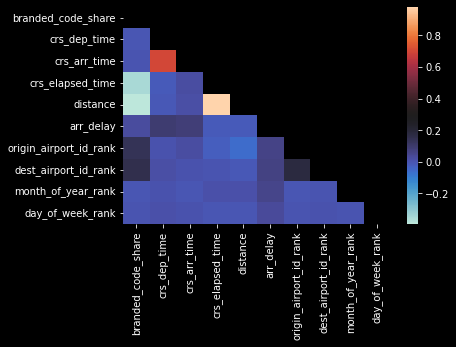

In [20]:
feature_correlation = flights_subspace.corr()
mask = np.triu(feature_correlation) # mask the upper triangle

sns.heatmap(feature_correlation, cmap='icefire', mask=mask)

In [21]:
feature_correlation

,branded_code_share,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,origin_airport_id_rank,dest_airport_id_rank,month_of_year_rank,day_of_week_rank
branded_code_share,1.000000,-0.007760,-0.001551,-0.353433,-0.396218,0.024217,0.132184,0.149496,-0.003566,0.000722
crs_dep_time,-0.007760,1.000000,0.699596,-0.018583,-0.010345,0.091357,0.003832,0.013654,0.002345,0.012774
crs_arr_time,-0.001551,0.699596,1.000000,0.020783,0.015985,0.081350,0.021448,0.004686,-0.005573,0.005816
crs_elapsed_time,-0.353433,-0.018583,0.020783,1.000000,0.981937,-0.014067,-0.025010,-0.000091,0.007992,-0.007237
distance,-0.396218,-0.010345,0.015985,0.981937,1.000000,-0.014238,-0.061991,-0.011217,0.010457,-0.008201
arr_delay,0.024217,0.091357,0.081350,-0.014067,-0.014238,1.000000,0.061080,0.066292,0.053999,0.029904
origin_airport_id_rank,0.132184,0.003832,0.021448,-0.025010,-0.061991,0.061080,1.000000,0.175874,-0.005413,-0.001960
dest_airport_id_rank,0.149496,0.013654,0.004686,-0.000091,-0.011217,0.066292,0.175874,1.000000,-0.002606,0.002574
month_of_year_rank,-0.003566,0.002345,-0.005573,0.007992,0.010457,0.053999,-0.005413,-0.002606,1.000000,-0.001005
day_of_week_rank,0.000722,0.012774,0.005816,-0.007237,-0.008201,0.029904,-0.001960,0.002574,-0.001005,1.000000


Unfortunately our features are better correlated with each other than our target.

#### Storing the engineered data

In [ ]:
flights_subspace = flights_subspace.drop('fl_date', axis=1)

flights_subspace.to_csv('../files/flights_engi.csv', index=False)
flights_test.to_csv('../files/flights_test_engi.csv', index=False)